# **Recommendation system**

---
## Step 01: **Import Libraries**
---

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from src.recommender import recommend
from src.model import MF, MF_bias, train_epochs

from scipy.sparse import csr_matrix

#np.random.seed(seed=33) # for reproducability

---
## Step 02: **Load Data**
---

In [2]:
movies = pd.read_csv("data/ml-latest-small/movies.csv")
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [3]:
ratings = pd.read_csv("data/ml-latest-small/ratings.csv")
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


---
## Step 03: **Data Pre-processing**
---

### **Removing unrated movies**

In [4]:
# list of movies in "ratings" dataset that are not in "movies" dataset
ex1 = np.setdiff1d(ratings.movieId.unique(), movies.movieId.unique()).tolist()
print(f"No. of movies in ratings.csv but not in movies.csv: {len(ex1)}")
# list of movies in "movies" dataset that are not in "ratings" dataset
ex2 = np.setdiff1d(movies.movieId.unique(), ratings.movieId.unique()).tolist()
print(f"No. of movies in movies.csv but not in ratings.csv: {len(ex2)}")

# remove the extra movies form "movies" dataset which are not in "ratings" dataset
movies = movies[movies.movieId.isin(ex2) == False]
movies.reset_index(drop=True, inplace=True) # reset the index after removing some rows
print("unrated movies removed from movies dataset")

No. of movies in ratings.csv but not in movies.csv: 0
No. of movies in movies.csv but not in ratings.csv: 18
unrated movies removed from movies dataset


### **Encoding**
We encode the data to have contiguous id's for users and movies. You can think about this as a categorical encoding of our two categorical variables `userId` and `movieId`.

In [5]:
lbl_user = LabelEncoder()
lbl_movie = LabelEncoder()
lbl2_movie = LabelEncoder()
ratings.userId = lbl_user.fit_transform(ratings.userId.values)
movies.movieId = lbl_movie.fit_transform(movies.movieId.values)
ratings.movieId = lbl2_movie.fit_transform(ratings.movieId.values)

### **Retrieve Movies Genres**

In the movies dataset, `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.

In [6]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head(3)

,movieId,title,genres
0,0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,2,Grumpier Old Men (1995),"[Comedy, Romance]"


### **Creating Sparse Utility Matrix**

In [7]:
num_users = ratings.userId.nunique()    # no. of unique users
num_items = ratings.movieId.nunique()   # no. of unique movies

rows = ratings.userId.values            # user id's
cols = ratings.movieId.values           # movie id's
rat = ratings.rating.values             # ratings

# sparse utility matrix
utility = csr_matrix((rat, (rows, cols)), shape=(num_users, num_items))

---
## Step 04: **Exploratory Data Analysis**
---

In [8]:
# calculate the sparsity of the utility matrix
sparsity = len(ratings.rating) / (ratings.userId.nunique() * ratings.movieId.nunique())
print(f"Utility Matrix Sparsity: {round(sparsity*100, 2)}%")

Utility Matrix Sparsity: 1.7%


In [9]:
print("--------------------------------------")
print("|            movies.csv              |")
print("--------------------------------------")
print(f"shape                : {movies.shape}")
print(f"No. of unique movies : {movies.movieId.nunique()}   (min: {movies.movieId.min()}, max: {movies.movieId.max()})")
print("")

print("--------------------------------------")
print("|            ratings.csv             |")
print("--------------------------------------")
print(f"shape                : {ratings.shape}")

n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()
n_ratings_per_user = ratings.groupby(['userId'])[['rating']].count()
n_ratings_per_movie = ratings.groupby(['movieId'])[['rating']].count()

print(f"No. of ratings       : {n_ratings}")
print(f"No. of unique users  : {n_users}    (min: {ratings.userId.min()}, max: {ratings.userId.max()})")
print(f"No. of unique movies : {n_movies}   (min: {ratings.movieId.min()}, max: {ratings.movieId.max()})")
print(f"unique rating values : {sorted(ratings.rating.unique().tolist())}")
print(70*'-')
print(f"No. of ratings per user  - | Min:{n_ratings_per_user.min().item()} | Avg:{round(n_ratings/n_users, 2)} | Max:{n_ratings_per_user.max().item()} |")
print(f"No. of ratings per movie - | Min:{n_ratings_per_movie.min().item()}  | Avg:{round(n_ratings/n_movies, 2)} | Max:{n_ratings_per_movie.max().item()}  |")
print(70*'-')
print(f"Mean global rating: {round(ratings['rating'].mean(), 2)}")
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(), 2)}")

--------------------------------------
|            movies.csv              |
--------------------------------------
shape                : (9724, 3)
No. of unique movies : 9724   (min: 0, max: 9723)

--------------------------------------
|            ratings.csv             |
--------------------------------------
shape                : (100836, 4)
No. of ratings       : 100836
No. of unique users  : 610    (min: 0, max: 609)
No. of unique movies : 9724   (min: 0, max: 9723)
unique rating values : [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
----------------------------------------------------------------------
No. of ratings per user  - | Min:20 | Avg:165.3 | Max:2698 |
No. of ratings per movie - | Min:1  | Avg:10.37 | Max:329  |
----------------------------------------------------------------------
Mean global rating: 3.5
Mean rating per user: 3.66


In [10]:
# retrieve genres distribution
genres_dict = {}
for genres in movies['genres']:
    for genre in genres:
        if genre in genres_dict:
            genres_dict[genre] += 1
        else:
            genres_dict[genre] = 1
#print(f"There are {len(genres_dict.keys())} genres.")

b = sorted(genres_dict, key=genres_dict.get, reverse=True)[0:5]
print("The 5 most common genres:")
for i in b:
    print(f"{i}, {genres_dict[i]} movies")

The 5 most common genres:
Drama, 4349 movies
Comedy, 3753 movies
Thriller, 1889 movies
Action, 1828 movies
Romance, 1591 movies


In [11]:
A = ratings.groupby(['movieId'])[['rating']].mean()
B = ratings.groupby(['movieId'])[['rating']].count()
stats = pd.merge(A, B, on='movieId')
stats.columns = ['rating_avg', 'count']
stats = pd.merge(stats, movies, on='movieId')
#stats = stats.drop(['genres'], axis=1)
stats = stats[['movieId', 'title', 'count', 'rating_avg', 'genres']]
stats.head()

,movieId,title,count,rating_avg,genres
0,0,Toy Story (1995),215,3.920930,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,Jumanji (1995),110,3.431818,"[Adventure, Children, Fantasy]"
2,2,Grumpier Old Men (1995),52,3.259615,"[Comedy, Romance]"
3,3,Waiting to Exhale (1995),7,2.357143,"[Comedy, Drama, Romance]"
4,4,Father of the Bride Part II (1995),49,3.071429,[Comedy]


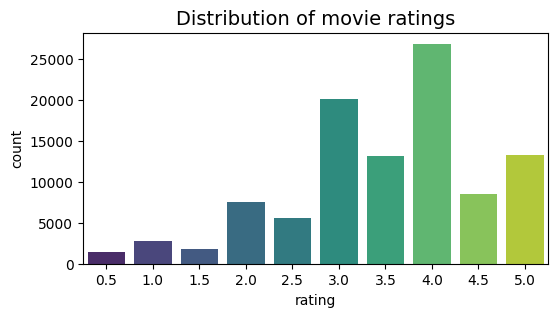

In [12]:
#sns.set_style("whitegrid")
plt.figure(figsize=(6,3))
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

The most common rating is 4.0, while lower ratings such as 0.5 or 1.0 are much more rare. it deduces that users mostly rate the movies they liked.

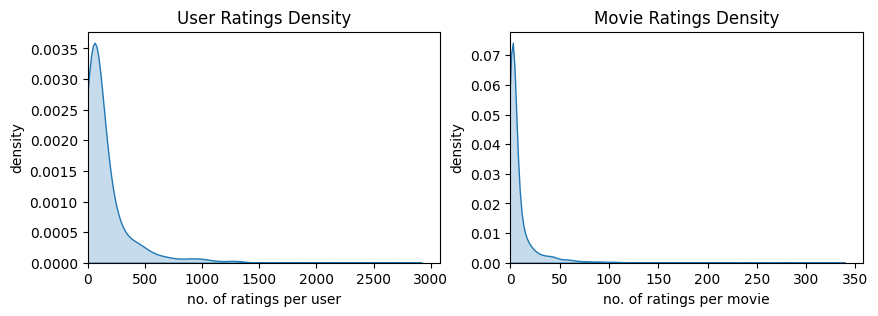

In [13]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user.values.squeeze(), shade=True)
plt.xlim(0)
plt.title("User Ratings Density")
plt.xlabel("no. of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie.values.squeeze(), shade=True)
plt.xlim(0)
plt.title("Movie Ratings Density")
plt.xlabel("no. of ratings per movie")
plt.ylabel("density")
plt.show()

### **Best vs. Worst Movie**
which movie has the lowest and highest average rating?

In [14]:
worst = stats[stats['rating_avg']==stats['rating_avg'].min()].sort_values('count', ascending=True).iloc[0,:]
best = stats[stats['rating_avg']==stats['rating_avg'].max()].sort_values('count', ascending=False).iloc[0,:]
pd.DataFrame(
    {
    'movieId':[worst['movieId'], best['movieId']], 
    'title':[worst['title'], best['title']], 
    'average rating':[worst['rating_avg'], best['rating_avg']], 
    'No. of votes':[worst['count'], best['count']]
    }, 
    index=['Worst Movie', 'Best Movie']
    )

,movieId,title,average rating,No. of votes
Worst Movie,2685,Gypsy (1962),0.5,1
Best Movie,48,Lamerica (1994),5.0,2


Both movies have only 2 rates. A better approach for evaluating movie popularity is to look at the Bayesian average.

---
## Step 05: **Bayesian Average**
---

### IMDB's Weighted Rating

$s_i = w_i \cdot A_i + (1 - w_i) \cdot S$

where
* $A_i$ : average (arithmetic mean) rating of the $i^{\text{th}}$ item
* $S$ : average (arithmetic mean) rating of all items
* $w_i$ : weight given to $A_i$

$w_i = \dfrac{m_i}{m_i + m_{\text{avg}}}$

where
* $m_i$ : number of ratings for $i^{\text{th}}$ item
* $m_{\text{avg}}$ : average number of ratings of all items

**Note:** $m_{\text{avg}}$ can be also minimum votes required to be listed in the chart

$s_i = \dfrac{m_i}{m_i + m_{\text{avg}}} \cdot A_i + \dfrac{m_{\text{avg}}}{m_i + m_{\text{avg}}} \cdot S$

In [15]:
A = stats['rating_avg']         # average rating of movie
S = stats['rating_avg'].mean()  # average rating of all items
m = stats['count']              # no. of rating of movies
m_avg = stats['count'].mean()   # average no. of rating of all movies
w = m / (m + m_avg)             # calculate the weight
x = w*A + (1-w)*S               # calculate bayesian average for all movies
stats['bayesian_avg'] = x       # adding the bayesian averages
stats = stats.sort_values('bayesian_avg', ascending=False)
stats = stats[['movieId', 'title', 'count', 'rating_avg', 'bayesian_avg', 'genres']]

### **BEST Movies**

In [16]:
stats.head()

,movieId,title,count,rating_avg,bayesian_avg,genres
277,277,"Shawshank Redemption, The (1994)",317,4.429022,4.392070,"[Crime, Drama]"
659,659,"Godfather, The (1972)",192,4.289062,4.236457,"[Crime, Drama]"
2224,2224,Fight Club (1999),218,4.272936,4.227052,"[Action, Crime, Drama, Thriller]"
224,224,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.192646,"[Action, Adventure, Sci-Fi]"
46,46,"Usual Suspects, The (1995)",204,4.237745,4.190567,"[Crime, Mystery, Thriller]"


### **WORST Movies**

In [17]:
stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,title,count,rating_avg,bayesian_avg,genres
1172,1172,Speed 2: Cruise Control (1997),19,1.605263,2.190377,"[Action, Romance, Thriller]"
2679,2679,Battlefield Earth (2000),19,1.657895,2.224426,"[Action, Sci-Fi]"
1372,1372,Godzilla (1998),33,1.954545,2.267268,"[Action, Sci-Fi, Thriller]"
1144,1144,Anaconda (1997),27,1.925926,2.296800,"[Action, Adventure, Thriller]"
1988,1988,Superman IV: The Quest for Peace (1987),16,1.687500,2.306841,"[Action, Adventure, Sci-Fi]"


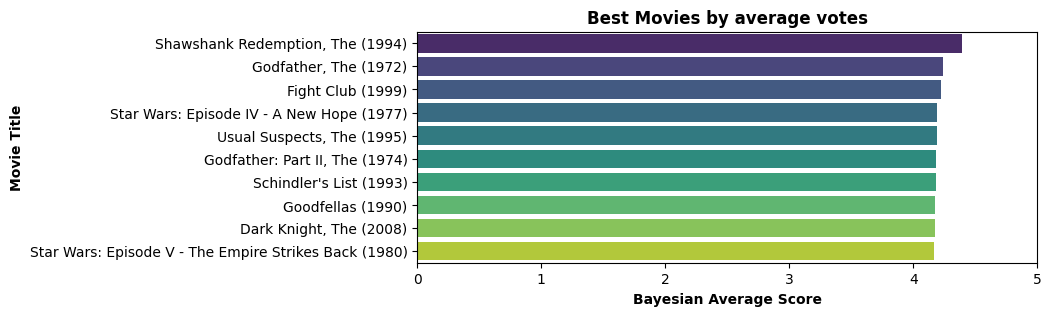

In [18]:
#sns.set_style("whitegrid")
plt.figure(figsize=(8,3))
ax = sns.barplot(x=stats['bayesian_avg'].head(10), y=stats['title'].head(10), data=stats, palette="viridis")
plt.xlim(0, 5)
plt.title('Best Movies by average votes', weight='bold')
plt.xlabel('Bayesian Average Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')
plt.show()

<Figure size 1200x300 with 0 Axes>

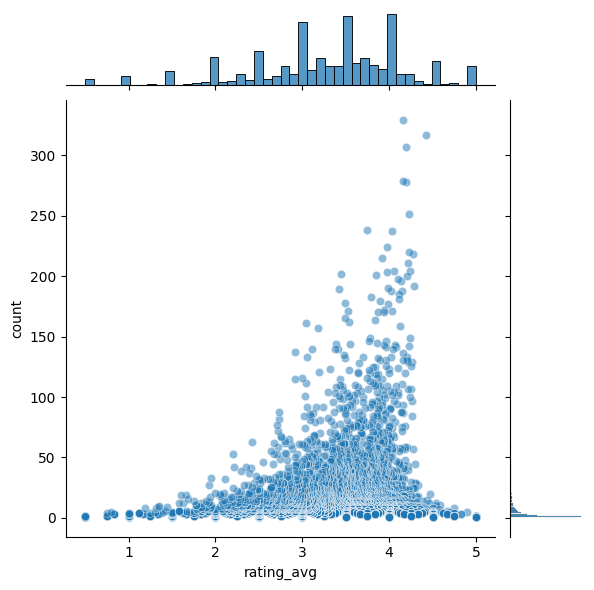

In [20]:
plt.figure(figsize=(12,3))
ax = sns.jointplot(x='rating_avg', y='count', data=stats, alpha=0.5)
plt.show()

---
## Step 06: **Split Data**
---

In [21]:
# split data to two parts (train 60% , X 40%)
train, X = train_test_split(ratings, test_size=0.4, shuffle = True, random_state = 8)

X = X[X['userId'].isin(train['userId'])]   # removing the users that are not available in train dataset
X = X[X['movieId'].isin(train['movieId'])] # removing the movies that are not available in train dataset

# split "X" dataset to two parts (valid 50% , test 50%)
valid, test = train_test_split(X, test_size=0.5, shuffle = True, random_state = 8)

# so at the end we have 3 parts (train, valid and test)

# quality check, if there are any user or movie in valid and test dataset that are not in train dataset
if (len(np.setdiff1d(valid.userId.unique(), train.userId.unique()).tolist()) == 0 and 
    len(np.setdiff1d(valid.movieId.unique(), train.movieId.unique()).tolist()) == 0 and 
    len(np.setdiff1d(test.userId.unique(), train.userId.unique()).tolist()) == 0 and 
    len(np.setdiff1d(test.movieId.unique(), train.movieId.unique()).tolist()) == 0):
    print('Split is done correctly!')
else:
    print("Wrong data split!")

Split is done correctly!


In [22]:
print('ratings.shape : ', ratings.shape)
print('train.shape   : ', train.shape)
print('valid.shape   : ', valid.shape)
print('test.shape    : ', test.shape)
print("---------------------------------------------")
print(f"Train Data --> unique users: {train.userId.nunique()}, unique movies: {train.movieId.nunique()}")
print(f"Valid Data --> unique users: {valid.userId.nunique()},  unique movies: {valid.movieId.nunique()}")
print(f"Test Data  --> unique users: {test.userId.nunique()},  unique movies: {test.movieId.nunique()}")

ratings.shape :  (100836, 4)
train.shape   :  (60501, 4)
valid.shape   :  (19119, 4)
test.shape    :  (19119, 4)
---------------------------------------------
Train Data --> unique users: 610, unique movies: 8048
Valid Data --> unique users: 609,  unique movies: 4201
Test Data  --> unique users: 609,  unique movies: 4251


---
## Step 07: **Train Data**
---

### **Cross-validation**

In [23]:
num_users = ratings.userId.nunique()    # no. of unique users
num_items = ratings.movieId.nunique()   # no. of unique movies

param_list = np.linspace(10,150,15, dtype=np.int32) # list of parameters (latent factor)
param_error = {}
# train the model with different values for latent factor
for param in param_list:
    # create the model with specified latent factor
    model = MF_bias(num_users, num_items, emb_size=param)
    # train the model
    history = train_epochs(
        model=model, 
        train_data=train, 
        test_data=valid, 
        epochs=50, 
        device='cpu', 
        lr=0.01, 
        wd=1e-5, 
        save=False, 
        verbose=False
        )
    training_loss = history['train_loss'][-1]
    validation_loss = history['valid_loss'][-1]
    print(f"latent factor: {param}, train loss: {training_loss:.3f} valid loss: {validation_loss:.3f}")
    param_error[param] = validation_loss

latent factor: 10, train loss: 0.749 valid loss: 0.870
latent factor: 20, train loss: 0.743 valid loss: 0.935
latent factor: 30, train loss: 0.640 valid loss: 0.867
latent factor: 40, train loss: 0.692 valid loss: 0.909
latent factor: 50, train loss: 0.705 valid loss: 0.895
latent factor: 60, train loss: 0.666 valid loss: 0.844
latent factor: 70, train loss: 0.624 valid loss: 0.807
latent factor: 80, train loss: 0.605 valid loss: 0.800
latent factor: 90, train loss: 0.611 valid loss: 0.813
latent factor: 100, train loss: 0.627 valid loss: 0.830
latent factor: 110, train loss: 0.641 valid loss: 0.839
latent factor: 120, train loss: 0.644 valid loss: 0.836
latent factor: 130, train loss: 0.637 valid loss: 0.826
latent factor: 140, train loss: 0.624 valid loss: 0.813
latent factor: 150, train loss: 0.610 valid loss: 0.803


In [24]:
k = min(param_error, key=param_error.get)
print(f"Best number of latent factor is {k}")

Best number of latent factor is 80


In [34]:
# train the model with best latent factor
model = MF(num_users, num_items, emb_size=k)
history = train_epochs(
    model=model, 
    train_data=train, 
    test_data=valid, 
    epochs=300, 
    device='cpu', 
    lr=0.001, 
    wd=1e-5, 
    save=False, 
    verbose=False
    )

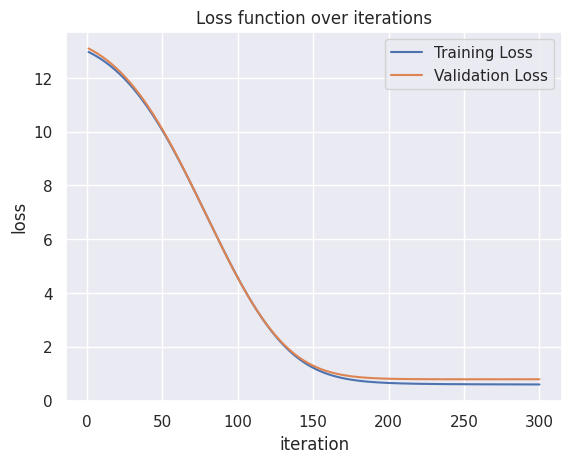

In [35]:
sns.set()
def plot_learning_curve(history):
    iter_array = list(range(1, len(history['train_loss'])+1))
    plt.plot(iter_array, history['train_loss'], label='Training Loss')
    plt.plot(iter_array, history['valid_loss'], label='Validation Loss')
    plt.title("Loss function over iterations")
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend(loc='best')

plot_learning_curve(history)

---
## Step 08: **Evaluation**
---

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error

t_users = torch.tensor(test.userId.values) # users from test set
t_items = torch.tensor(test.movieId.values) # movies from test set
y_true = test.rating.values # actual movie rating by users
with torch.no_grad():
    y_preds = model(t_users, t_items) # predicted movie rating by users
y_preds = y_preds.detach().numpy()
thershold = 3.0 # the thresholf for rating to consider coresponding movie liked by user
y_true_binary = (y_true > thershold).astype(int) # actual binaries (1 if user likes movie and 0 if doesn't)
y_preds_binary = (y_preds > thershold).astype(int) # predicted binaries (1 if user likes movie and 0 if doesn't)

precision = precision_score(y_true_binary, y_preds_binary)
recall = recall_score(y_true_binary, y_preds_binary, pos_label=1)
f1 = f1_score(y_true_binary, y_preds_binary)
mse = mean_squared_error(y_true, y_preds)
print(f"Precision Score    : {precision*100:.2f}%")
print(f"Recall Score       : {recall*100:.2f}%")
print(f"F1 Score           : {f1*100:.2f}%")
print(f"Mean Squared Error : {mse:.2f}")

Precision Score    : 70.94%
Recall Score       : 90.94%
F1 Score           : 79.70%
Mean Squared Error : 0.80


---
## Step 09: **Make Recommendation**
---

### **Train with optimal hyperparameter and whole dataset**

In [41]:
model = MF(num_users, num_items, emb_size=k)
history = train_epochs(
    model=model, 
    train_data=ratings, 
    test_data=None, 
    epochs=100, 
    device='cpu', 
    lr=0.01, 
    wd=1e-5, 
    save=False, 
    verbose=True
    )

epoch [1/100] - train loss 13.000
epoch [10/100] - train loss 7.004
epoch [20/100] - train loss 0.901
epoch [30/100] - train loss 1.039
epoch [40/100] - train loss 0.844
epoch [50/100] - train loss 0.645
epoch [60/100] - train loss 0.648
epoch [70/100] - train loss 0.642
epoch [80/100] - train loss 0.625
epoch [90/100] - train loss 0.622
epoch [100/100] - train loss 0.619


### **Recommendation**

In [44]:
userID = 760
print(f"Movie Recommendations for user {userID}:")
recommend(model, ratings, movies, stats, user_id=userID, num_recom=5)

Movie Recommendations for user 760:


,movieId,title,count,rating_avg,bayesian_avg,genres
277,277,"Shawshank Redemption, The (1994)",317,4.429022,4.392070,"[Crime, Drama]"
659,659,"Godfather, The (1972)",192,4.289062,4.236457,"[Crime, Drama]"
2224,2224,Fight Club (1999),218,4.272936,4.227052,"[Action, Crime, Drama, Thriller]"
224,224,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.192646,"[Action, Adventure, Sci-Fi]"
46,46,"Usual Suspects, The (1995)",204,4.237745,4.190567,"[Crime, Mystery, Thriller]"
